<a href="https://colab.research.google.com/github/Aether-ious/production-ml-portfolio/blob/main/OmniXAI_Library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%%writefile omnixai_lib.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
import warnings

# Suppress warnings for cleaner output in demo
warnings.filterwarnings('ignore')

class OmniExplainer:
    """
    Base class for the OmniXAI Lite package.
    """
    def __init__(self, model, data, feature_names=None, mode='classification'):
        self.model = model
        self.data = np.array(data)
        self.feature_names = feature_names if feature_names is not None else [f"Feat_{i}" for i in range(data.shape[1])]
        self.mode = mode

        # Pre-compute statistics for perturbation logic
        self.means = np.mean(self.data, axis=0)
        self.stds = np.std(self.data, axis=0)
        self.mins = np.min(self.data, axis=0)
        self.maxs = np.max(self.data, axis=0)

    def predict(self, data):
        """Unified prediction interface."""
        if self.mode == 'classification':
            # Returns probability of class 1
            return self.model.predict_proba(data)[:, 1]
        return self.model.predict(data)

class PartialDependence(OmniExplainer):
    """
    Global Model-Agnostic Method: Partial Dependence Plot (PDP).

    INTUITION:
    Marginalizes the model output over the distribution of the features
    in set C (complement), so that the function shows the relationship
    between the features in set S (target) and the predicted outcome.

    Math:
    f_S(x_S) = E_{x_C} [ f(x_S, x_C) ]
    Approximated by averaging predictions over the training data
    where the target feature is forced to a specific value.
    """

    def explain(self, feature_idx, grid_resolution=50):
        """
        Computes PDP for a single feature.
        """
        feature_name = self.feature_names[feature_idx]
        print(f"--- Computing Partial Dependence for {feature_name} ---")

        # Create grid
        min_val = self.mins[feature_idx]
        max_val = self.maxs[feature_idx]
        grid = np.linspace(min_val, max_val, grid_resolution)

        y_means = []
        y_stds = []

        # For each value in the grid
        for val in grid:
            # Copy data
            temp_data = self.data.copy()
            # Force feature to value
            temp_data[:, feature_idx] = val
            # Predict
            preds = self.predict(temp_data)
            # Aggregate
            y_means.append(np.mean(preds))
            y_stds.append(np.std(preds))

        return {
            'feature': feature_name,
            'grid': grid,
            'means': np.array(y_means),
            'stds': np.array(y_stds)
        }

class LimeLite(OmniExplainer):
    """
    Local Model-Agnostic Method: LIME (Simplified).

    INTUITION:
    Approximates a complex non-linear model locally with a simple interpretable
    linear model.

    Algorithm:
    1. Generate perturbed samples around the instance of interest (Gaussian sampling).
    2. Get predictions for these samples using the black-box model.
    3. Weight samples by their proximity (exponential kernel) to the original instance.
    4. Fit a weighted linear regression (Lasso/Ridge) on the perturbed samples.
    5. The coefficients of this linear model explain the local behavior.
    """

    def explain(self, instance, n_samples=5000, kernel_width=0.75):
        print("--- Computing LIME Explanation ---")
        instance = np.array(instance).reshape(1, -1)
        num_features = self.data.shape[1]

        # 1. Generate Perturbed Samples (Gaussian neighborhood)
        # Scale noise by feature standard deviations
        noise = np.random.normal(0, 1, size=(n_samples, num_features))
        scaled_noise = noise * self.stds
        perturbed_data = instance + scaled_noise

        # 2. Get Black-box Predictions
        predictions = self.predict(perturbed_data)

        # 3. Calculate Weights (Exponential Kernel)
        # Euclidean distance between perturbed samples and original instance
        distances = pairwise_distances(perturbed_data, instance, metric='euclidean').ravel()
        # Normalize distances
        distances = distances / np.max(distances)
        weights = np.sqrt(np.exp(-(distances ** 2) / kernel_width ** 2))

        # 4. Fit Explainable Linear Model (Ridge Regression with sample weights)
        # We model: Prediction ~ PerturbedFeatures
        # Uses Ridge to handle potential multicollinearity in perturbations
        simpler_model = Ridge(alpha=1.0, fit_intercept=True)
        simpler_model.fit(perturbed_data, predictions, sample_weight=weights)

        coeffs = simpler_model.coef_

        # Sort by absolute impact
        sorted_indices = np.argsort(np.abs(coeffs))[::-1]

        explanation = []
        for i in sorted_indices:
            explanation.append((self.feature_names[i], coeffs[i]))

        return {
            'intercept': simpler_model.intercept_,
            'feature_importance': explanation,
            'local_prediction': simpler_model.predict(instance)[0]
        }

class ShapSampler(OmniExplainer):
    """
    Local Model-Agnostic Method: KernelSHAP (Sampling Approximation).

    INTUITION:
    Based on Game Theory. The 'value' of a feature is its marginal contribution
    to the prediction, averaged over all possible coalitions of features.

    Simplified Algorithm (Sampling):
    1. Generate random binary masks (coalitions).
    2. 'Masked' features are replaced by random background samples (marginalization).
    3. Compute predictions for these hybrid samples.
    4. Solve a Weighted Linear Regression where the inputs are the binary masks
       and targets are the predictions.
    5. The coefficients are the SHAP values.
    """

    def explain(self, instance, n_samples=1000, n_background=10):
        print("--- Computing SHAP Values (Sampling) ---")
        instance = np.array(instance).reshape(1, -1)
        n_features = self.data.shape[1]

        # 1. Generate random binary masks (0=hidden, 1=present)
        # We ensure at least 50% ones to keep sampling relevant
        masks = np.random.randint(0, 2, size=(n_samples, n_features))

        # 2. Create dataset based on masks
        # If mask=1, use instance value. If mask=0, use random background sample.
        X_synthetic = np.zeros((n_samples * n_background, n_features))
        y_synthetic = np.zeros(n_samples * n_background)
        weights = np.zeros(n_samples * n_background)

        # Select background data to marginalize over
        bg_indices = np.random.choice(self.data.shape[0], n_background, replace=False)
        background_data = self.data[bg_indices]

        cursor = 0
        for i in range(n_samples):
            mask = masks[i]
            # SHAP Kernel Weight (Combines combinatorics of coalition size)
            # w = (M-1) / (comb(M, |z|) * |z| * (M-|z|))
            M = n_features
            z = np.sum(mask)
            if z == 0 or z == M:
                weight = 10000 # Enforce end-points
            else:
                # Simplified weight roughly proportional to inverse combinatorial
                weight = 1.0

            for j in range(n_background):
                # Construct hybrid sample
                # Hybrid = Instance * Mask + Background * (1-Mask)
                hybrid_sample = instance * mask + background_data[j] * (1 - mask)

                X_synthetic[cursor] = mask # We regress on the MASK, not the value
                # But we predict on the HYBRID value
                y_synthetic[cursor] = self.predict(hybrid_sample.reshape(1, -1))[0]
                weights[cursor] = weight
                cursor += 1

        # 4. Solve Weighted Linear Regression
        # Target: Prediction Gap. Features: Binary Masks.
        reg = LinearRegression()
        reg.fit(X_synthetic, y_synthetic, sample_weight=weights)

        shap_values = reg.coef_
        base_value = reg.intercept_

        # Sort
        sorted_indices = np.argsort(np.abs(shap_values))[::-1]
        explanation = [(self.feature_names[i], shap_values[i]) for i in sorted_indices]

        return {
            'base_value': base_value,
            'shap_values': explanation,
            'raw_values': shap_values
        }

class CounterfactualGen(OmniExplainer):
    """
    Example-Based Method: Counterfactual Explanations.

    INTUITION:
    "What is the smallest change to the features that would change the prediction?"
    Find x' such that Prediction(x') != Prediction(x) and dist(x, x') is minimized.

    Algorithm:
    A 'Shotgun' Random Search approach (Simple but effective for tabular data).
    1. Sample points in growing spheres around the instance.
    2. Check if the class prediction flips.
    3. Return the closest point that flips the class.
    """

    def generate(self, instance, n_tries=5000, search_radius=1.0):
        print("--- Searching for Counterfactuals ---")
        instance = np.array(instance).flatten()
        original_pred = self.model.predict(instance.reshape(1,-1))[0]

        best_cf = None
        min_dist = np.inf

        # Standardize search noise
        for _ in range(n_tries):
            # Generate random direction
            noise = np.random.normal(0, 1, size=len(instance))

            # Scale by random radius (searching closer first more likely)
            r = np.random.uniform(0.01, search_radius)
            perturbation = (noise * self.stds) * r

            candidate = instance + perturbation

            # Check prediction
            new_pred = self.model.predict(candidate.reshape(1,-1))[0]

            if new_pred != original_pred:
                # We found a counterfactual
                dist = np.linalg.norm(candidate - instance)
                if dist < min_dist:
                    min_dist = dist
                    best_cf = candidate

        if best_cf is None:
            return None

        # Calculate diffs
        diffs = []
        for i in range(len(instance)):
            if abs(best_cf[i] - instance[i]) > 0.001: # Threshold for display
                diffs.append((self.feature_names[i], instance[i], best_cf[i]))

        return {
            'original_class': original_pred,
            'cf_class': 1 - original_pred if self.mode == 'classification' else 'Changed',
            'counterfactual': best_cf,
            'changes': diffs,
            'distance': min_dist
        }

class OmniVisualizer:
    """Visualization utilities for the OmniXAI package."""

    @staticmethod
    def plot_pdp(pdp_result):
        plt.figure(figsize=(8, 5))
        plt.plot(pdp_result['grid'], pdp_result['means'], color='blue', linewidth=2)
        plt.fill_between(pdp_result['grid'],
                         pdp_result['means'] - pdp_result['stds'],
                         pdp_result['means'] + pdp_result['stds'],
                         color='blue', alpha=0.1)
        plt.title(f"Partial Dependence Plot: {pdp_result['feature']}")
        plt.xlabel(pdp_result['feature'])
        plt.ylabel("Average Model Prediction")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

    @staticmethod
    def plot_importance(explanation, title="Feature Importance"):
        names = [x[0] for x in explanation]
        vals = [x[1] for x in explanation]

        # Color positive/negative
        colors = ['green' if x > 0 else 'red' for x in vals]

        plt.figure(figsize=(10, 6))
        plt.barh(names[:10], vals[:10], color=colors[:10]) # Top 10
        plt.xlabel("Impact/Value")
        plt.title(title)
        plt.axvline(0, color='black', linewidth=0.8)
        plt.gca().invert_yaxis()
        plt.show()

Writing omnixai_lib.py


      OmniXAI Lite: Explainable AI Demo            

[1] Loading Breast Cancer Dataset (Binary Classification)...
[2] Training Random Forest (Black Box Model)...
    Test Accuracy: 0.96

[3] Explaining Instance #0
    Actual Label: 1
    Model Probability (Class 1): 0.9796

---------------------------------------------------
METHOD A: Partial Dependence (Global Sensitivity)
---------------------------------------------------
--- Computing Partial Dependence for mean radius ---


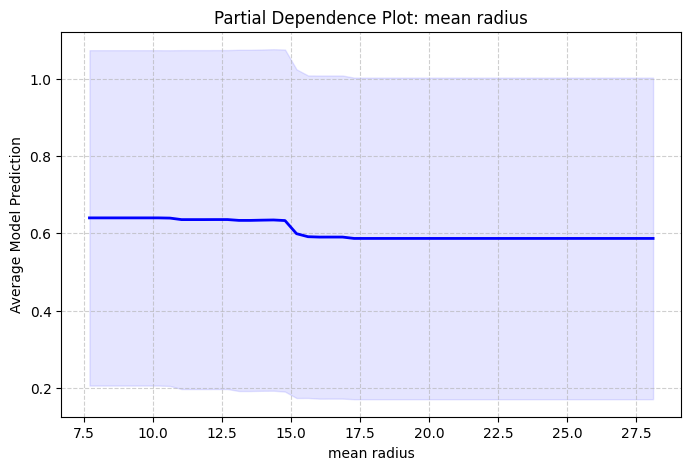

    > PDP shows how 'mean radius' affects prediction globally.

---------------------------------------------------
METHOD B: LIME (Local Interpretable Model-agnostic Explanations)
---------------------------------------------------
--- Computing LIME Explanation ---
    > Top 5 LIME Features (Linear Approximation):
      worst concave points     : -0.6927
      mean concave points      : -0.5828
      worst smoothness         : -0.3709
      symmetry error           : 0.2202
      mean concavity           : -0.1918


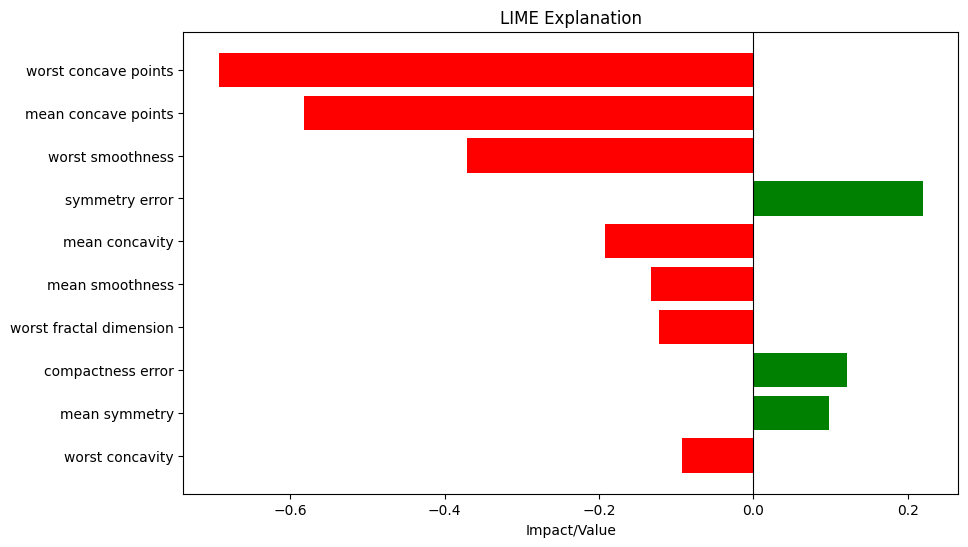


---------------------------------------------------
METHOD C: SHAP (Shapley Additive Explanations)
---------------------------------------------------
--- Computing SHAP Values (Sampling) ---
    > Base Value (Avg Prediction): 0.7848
    > Prediction (Sum of SHAP): 0.9341
    > Top 5 SHAP Values (Marginal Contribution):
      worst area               : 0.0421
      worst perimeter          : 0.0278
      mean concave points      : 0.0235
      worst concave points     : 0.0220
      worst radius             : 0.0200


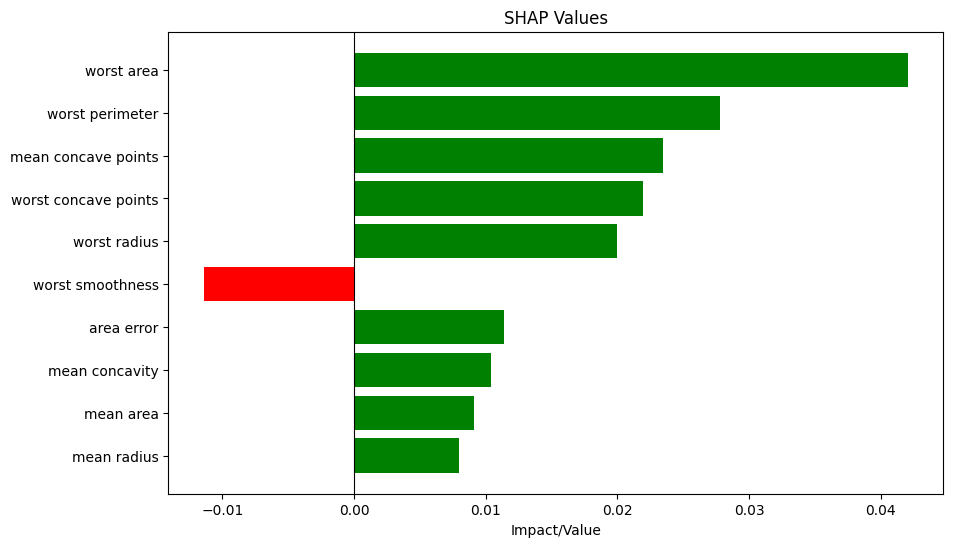


---------------------------------------------------
METHOD D: Counterfactuals (What-If Analysis)
---------------------------------------------------
--- Searching for Counterfactuals ---
    > Found Counterfactual! Distance: 54.8891
    > Original Prediction: 1
    > New Prediction:      0
    > Changes required to flip prediction:
      mean radius              : 12.47 -> 12.66
      mean texture             : 18.60 -> 12.84
      mean perimeter           : 81.09 -> 103.98
      mean area                : 481.90 -> 446.06
      mean smoothness          : 0.10 -> 0.09
      mean compactness         : 0.11 -> 0.11
      mean concavity           : 0.08 -> -0.01
      mean concave points      : 0.04 -> 0.14
      mean symmetry            : 0.19 -> 0.19
      mean fractal dimension   : 0.06 -> 0.05
      radius error             : 0.40 -> 0.42
      texture error            : 1.04 -> 0.74
      perimeter error          : 2.50 -> 8.31
      area error               : 30.29 -> 7.44
      co

In [5]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from omnixai_lib import (PartialDependence, LimeLite, ShapSampler,
                         CounterfactualGen, OmniVisualizer)

def main():
    print("===================================================")
    print("      OmniXAI Lite: Explainable AI Demo            ")
    print("===================================================\n")

    # 1. Load Data
    print("[1] Loading Breast Cancer Dataset (Binary Classification)...")
    data = load_breast_cancer()
    X = data.data
    y = data.target
    feature_names = data.feature_names

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 2. Train Black Box Model
    print("[2] Training Random Forest (Black Box Model)...")
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train, y_train)

    print(f"    Test Accuracy: {model.score(X_test, y_test):.2f}")

    # Select an interesting instance to explain (e.g., a positive case)
    target_idx = 0
    instance = X_test[target_idx]
    actual_label = y_test[target_idx]
    model_prob = model.predict_proba(instance.reshape(1, -1))[0, 1]

    print(f"\n[3] Explaining Instance #{target_idx}")
    print(f"    Actual Label: {actual_label}")
    print(f"    Model Probability (Class 1): {model_prob:.4f}")

    # ==========================================
    # Method A: Partial Dependence (Global)
    # ==========================================
    print("\n---------------------------------------------------")
    print("METHOD A: Partial Dependence (Global Sensitivity)")
    print("---------------------------------------------------")
    pdp = PartialDependence(model, X_train, feature_names)
    # Let's look at 'mean radius' (usually index 0)
    pdp_res = pdp.explain(feature_idx=0)
    OmniVisualizer.plot_pdp(pdp_res)
    print(f"    > PDP shows how '{pdp_res['feature']}' affects prediction globally.")

    # ==========================================
    # Method B: LIME (Local Surrogate)
    # ==========================================
    print("\n---------------------------------------------------")
    print("METHOD B: LIME (Local Interpretable Model-agnostic Explanations)")
    print("---------------------------------------------------")
    lime = LimeLite(model, X_train, feature_names)
    lime_res = lime.explain(instance)

    print("    > Top 5 LIME Features (Linear Approximation):")
    for feat, coef in lime_res['feature_importance'][:5]:
        print(f"      {feat:<25}: {coef:.4f}")

    OmniVisualizer.plot_importance(lime_res['feature_importance'], title="LIME Explanation")

    # ==========================================
    # Method C: SHAP (Game Theoretic)
    # ==========================================
    print("\n---------------------------------------------------")
    print("METHOD C: SHAP (Shapley Additive Explanations)")
    print("---------------------------------------------------")
    shap = ShapSampler(model, X_train, feature_names)
    shap_res = shap.explain(instance)

    print(f"    > Base Value (Avg Prediction): {shap_res['base_value']:.4f}")
    print(f"    > Prediction (Sum of SHAP): {shap_res['base_value'] + sum(v for k,v in shap_res['shap_values']):.4f}")
    print("    > Top 5 SHAP Values (Marginal Contribution):")
    for feat, val in shap_res['shap_values'][:5]:
        print(f"      {feat:<25}: {val:.4f}")

    OmniVisualizer.plot_importance(shap_res['shap_values'], title="SHAP Values")

    # ==========================================
    # Method D: Counterfactuals (Example Based)
    # ==========================================
    print("\n---------------------------------------------------")
    print("METHOD D: Counterfactuals (What-If Analysis)")
    print("---------------------------------------------------")
    cf_gen = CounterfactualGen(model, X_train, feature_names)
    cf_res = cf_gen.generate(instance, search_radius=2.0)

    if cf_res:
        print(f"    > Found Counterfactual! Distance: {cf_res['distance']:.4f}")
        print(f"    > Original Prediction: {cf_res['original_class']}")
        print(f"    > New Prediction:      {cf_res['cf_class']}")
        print("    > Changes required to flip prediction:")
        for feat, old, new in cf_res['changes']:
            print(f"      {feat:<25}: {old:.2f} -> {new:.2f}")
    else:
        print("    > No counterfactual found within search radius.")

if __name__ == "__main__":
    main()